In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [4]:
slice_df = pd.read_csv('../beast_results/MERGE_SLICE_DFS/slice_df.csv.gz', compression='gzip')
slice_df['tree_idx'] = slice_df['tree_idx'].astype(int)

In [5]:
slice_df

,uid,tree_idx,entry_idx,time,delta_expr,delta_bind_CGG
0,D15_M6_GC11,500,0,0.00,0.00000,0.00000
1,D15_M6_GC11,500,0,0.01,0.00000,0.00000
2,D15_M6_GC11,500,0,0.02,0.00000,0.00000
3,D15_M6_GC11,500,0,0.03,0.00000,0.00000
4,D15_M6_GC11,500,1,0.03,0.00000,0.00000
...,...,...,...,...,...,...
673682240,D20_M22_GC88,2499,77,1.00,-0.92755,-2.18001
673682241,D20_M22_GC88,2499,78,1.00,0.04300,-0.26491
673682242,D20_M22_GC88,2499,79,1.00,0.12209,-0.11339
673682243,D20_M22_GC88,2499,80,1.00,-0.01097,-1.05394


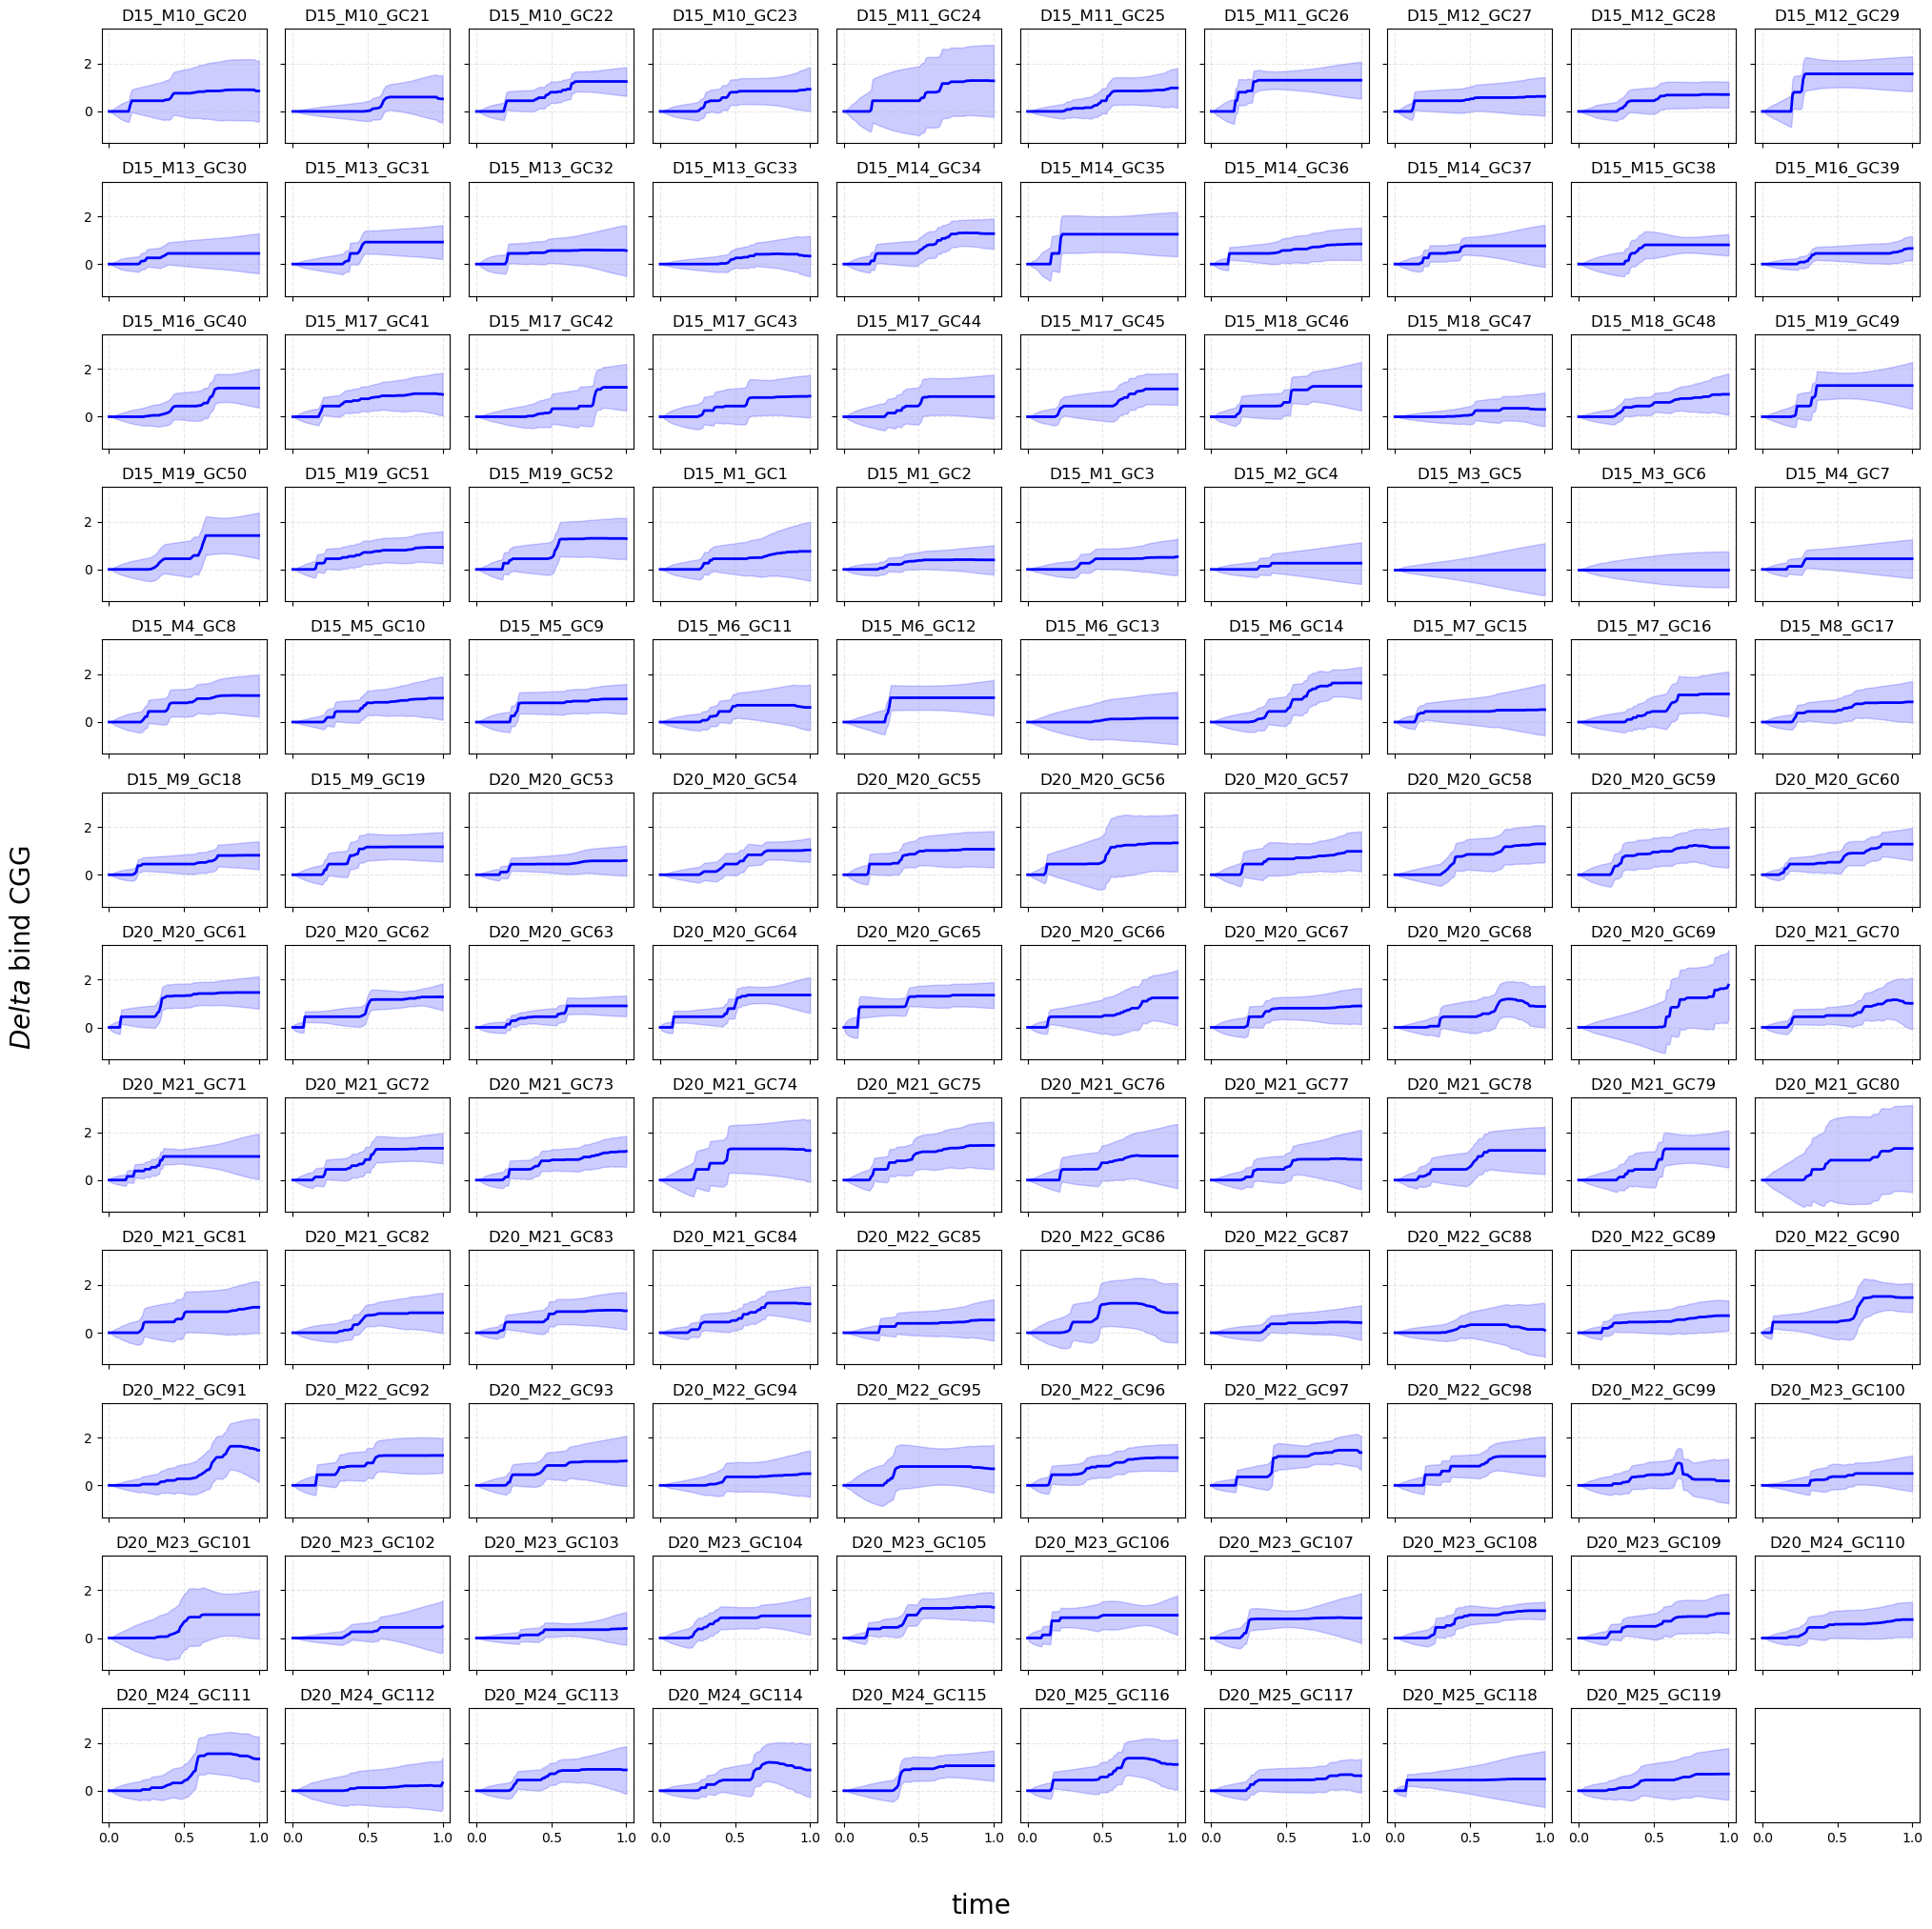

In [17]:
cols = 10
unique_uids = slice_df['uid'].unique()
rows = int(np.ceil(len(unique_uids) / cols))
fig, ax = plt.subplots(figsize=(20, 20), sharex=True, sharey=True, nrows=rows, ncols=cols)
# for idx, (uid, uid_df) in enumerate(zip(unique_uids, unique_uids)):
for idx, (uid, uid_df) in enumerate(slice_df.groupby("uid")):
    if idx >= cols * rows:
        break
    row = idx // cols
    col = idx % cols

    sns.lineplot(
        uid_df, 
        x='time', 
        y='delta_bind_CGG', 
        estimator='median', 
        errorbar="sd", 
        color='blue', 
        linewidth=2,
        ax=ax[row, col]
    )

    ax[row, col].set_title(uid)
    ax[row, col].set_ylabel(None)
    ax[row, col].set_xlabel(None)
    
    # ax[row, col].set_ylim(-0.5, 0.5)
    ax[row, col].grid(True, linestyle='--', alpha=0.3)
    # break
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.supylabel("$Delta$ bind CGG", fontsize=20, x=-0.01)
fig.supxlabel("time", fontsize=20, y=-0.01)
# fig.suptitle("Slice of CGG binding", fontsize=20)
fig.tight_layout()
plt.show()